# Crowd counter
For BP purposes

Norbert Matuška

In [7]:
import numpy as np
import pandas as pd
import math
import hashlib, hmac
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from tqdm.auto import tqdm
from scapy.layers.dot11 import Dot11
from scapy.all import rdpcap
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# ---------- USER CONFIG -----------------------------------------------------

In [8]:
PCAP_DIR       = Path("data/handover/gaussmarkov/60/25p")
FILE_GLOB      = "*.pcap"       # pattern for the capture files
GROUND_TRUTH   = 25             # expected pedestrians (for simple check)
SESSION_GAP    = 20             # DBSCAN eps === largest gap inside one visit
IDLE_TAIL      = 15             
TAU_SEC        = 200            # mean dwell before weight drops to 1/e -> Probabilistic Pressence Filter
STEP_SECONDS   = 1              # output resolution
VERBOSE        = True

# ---------- EXTRACT FRAMES -----------------------------------------------------


In [9]:
def extract_frames(pcap_path: Path):
    """Yield (relative_time, src_mac) tuples from one pcap file."""
    pkts = rdpcap(str(pcap_path), count=-1)
    if not pkts:
        return
    t0 = pkts[0].time                     # first packet = t=0
    for p in pkts:
        if not p.haslayer(Dot11):
            continue
        dot11 = p[Dot11]
        # skip control frames (type=1) - keep mgmt (0) & data (2)
        if dot11.type not in (0, 2):
            continue
        mac = dot11.addr2                 # transmitter address
        # ignore broadcast / multicast
        if mac is None or mac.lower().startswith(("ff:ff", "01:00")):
            continue
        mac = anon_mac(mac.lower())
        yield p.time - t0, mac.lower()

_ANON_KEY = bytes.fromhex(
    "d2c5f7b5c1a3e9d0ed9b2f0aff3c4eaab8f6c1a92463d4e17f5c9efa2e5be83c"
)

def anon_mac(mac: str, n_bytes: int = 8) -> str:
    raw = hmac.new(_ANON_KEY, mac.encode(), hashlib.sha256).digest()
    return raw[:n_bytes].hex()

records = []
t0_global = None                         # will hold the earliest timestamp

for pcap in tqdm(sorted(PCAP_DIR.glob(FILE_GLOB)), desc="Parsing pcaps"):
    for rel_time, mac in extract_frames(pcap):
        abs_ts = rel_time                  # will convert later anyway
        records.append((abs_ts, mac))
        if t0_global is None or abs_ts < t0_global:
            t0_global = abs_ts

df = pd.DataFrame(records, columns=["abs_time", "mac"])
if df.empty:
    raise RuntimeError("No usable 802.11 frames found – check PCAP_DIR / pattern")

# convert to simulation-relative time once, *after* all pcaps are merged
df["time"] = df["abs_time"] - t0_global  # 0s = first packet of entire trace
df.drop(columns="abs_time", inplace=True)

df.sort_values("time", inplace=True)
df.reset_index(drop=True, inplace=True)

if VERBOSE:
    print(f"Parsed {len(df):,} frames, {df['mac'].nunique()} unique MACs")


Parsing pcaps:   0%|          | 0/40 [00:00<?, ?it/s]

Parsed 80,593 frames, 30 unique MACs


# ---------- Crowd-size via DBSCAN sessions ----------------------------------


Estimated crowd = 22 (eps=20s) -> error -3 people


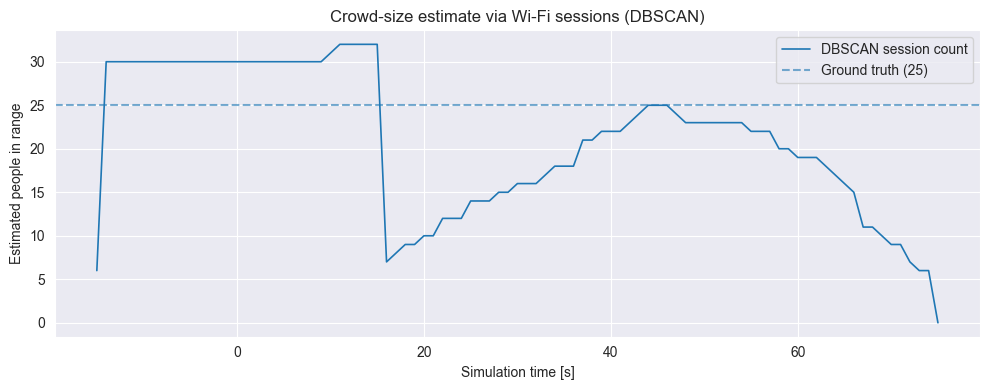

In [10]:
sessions = []         # list of (start, end) tuples AFTER dilation

for mac, grp in df.groupby('mac'):
    times = grp['time'].to_numpy().reshape(-1, 1)
    labels = DBSCAN(eps=SESSION_GAP, min_samples=1).fit_predict(times)

    for lab in np.unique(labels):
        ts = times[labels == lab].flatten()
        start  = ts.min() - IDLE_TAIL        # extend left
        end    = ts.max() + IDLE_TAIL        # extend right
        sessions.append((start, end))

if not sessions:
    raise RuntimeError("No sessions formed – check parameters or input")

sessions = np.array(sessions)

# ---------- Build time series ----------------------------------------------
t_min, t_max = sessions[:, 0].min(), sessions[:, 1].max()
ts = np.arange(t_min, t_max + STEP_SECONDS, STEP_SECONDS)

starts_sorted = np.sort(sessions[:, 0])
ends_sorted   = np.sort(sessions[:, 1])
active = 0
idx_start = idx_end = 0
counts = []

for t in ts:
    while idx_start < len(starts_sorted) and starts_sorted[idx_start] <= t:
        active += 1
        idx_start += 1
    while idx_end < len(ends_sorted) and ends_sorted[idx_end] < t:
        active -= 1
        idx_end += 1
    counts.append(active)

series = pd.Series(counts, index=ts, name="crowd_size_dbscan_dilated")

# simple evaluation
est_overall = int(round(series.median()))
error = est_overall - GROUND_TRUTH
print(f"Estimated crowd = {est_overall} (eps={SESSION_GAP}s) "
      f"-> error {error:+d} people")

# visualization
plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, lw=1.2, label="DBSCAN session count")
plt.axhline(GROUND_TRUTH, ls="--", alpha=.6, label=f"Ground truth ({GROUND_TRUTH})")
plt.xlabel("Simulation time [s]")
plt.ylabel("Estimated people in range")
plt.title("Crowd-size estimate via Wi-Fi sessions (DBSCAN)")
plt.legend()
plt.tight_layout()
plt.show()


# ---------- Crowd-size via GAP-SPLIT sessions -------------------------------


Estimated crowd = 22 (eps=20s) -> error -3 people


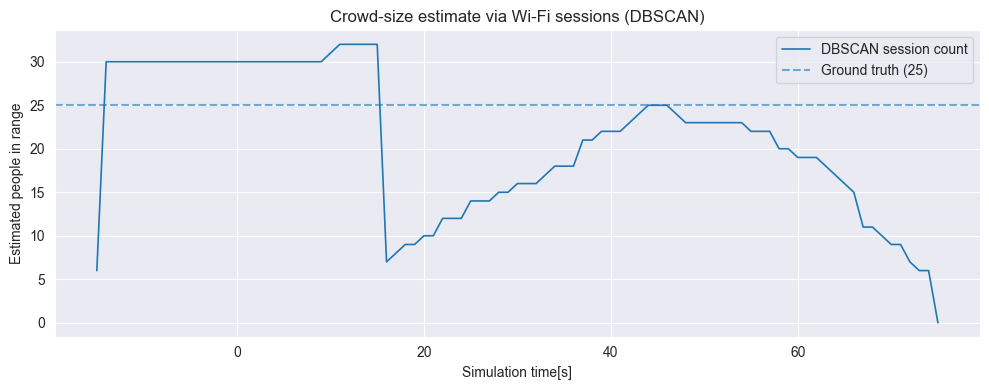

In [11]:
sessions = []

for mac, grp in df.groupby("mac"):
    # 1-D array of sorted packet times for this MAC
    times = grp["time"].to_numpy()
    if len(times) == 0:
        continue

    # indices where the gap > SESSION_GAP -> new session starts
    split_idx = np.where(np.diff(times) > SESSION_GAP)[0] + 1
    segments = np.split(times, split_idx)

    for seg in segments:
        start = seg[0] - IDLE_TAIL   # extend left
        end   = seg[-1] + IDLE_TAIL  # extend right
        sessions.append((start, end))

if not sessions:
    raise RuntimeError("No sessions formed – check parameters or input")

sessions = np.asarray(sessions)

# ---------- Build the time series ------------------------------------------
t_min, t_max = sessions[:, 0].min(), sessions[:, 1].max()
ts = np.arange(t_min, t_max + STEP_SECONDS, STEP_SECONDS)

# two sorted helper lists for an O(N logN) sweep
starts_sorted = np.sort(sessions[:, 0])
ends_sorted   = np.sort(sessions[:, 1])

active = 0
idx_start = idx_end = 0
counts = []

for t in ts:
    # add sessions that start before/at t
    while idx_start < len(starts_sorted) and starts_sorted[idx_start] <= t:
        active += 1
        idx_start += 1
    # remove sessions that already ended (< t)
    while idx_end < len(ends_sorted) and ends_sorted[idx_end] < t:
        active -= 1
        idx_end += 1
    counts.append(active)

series = pd.Series(counts, index=ts, name="crowd_size_gap_split")

est_overall = int(round(series.median()))    # robust overall estimate
error = est_overall - GROUND_TRUTH
print(f"Estimated crowd = {est_overall} (eps={SESSION_GAP}s) "
      f"-> error {error:+d} people")

# visualization
plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, lw=1.2, label="DBSCAN session count")
plt.axhline(GROUND_TRUTH, ls="--", alpha=.6, label=f"Ground truth ({GROUND_TRUTH})")
plt.xlabel("Simulation time[s]")
plt.ylabel("Estimated people in range")
plt.title("Crowd-size estimate via Wi-Fi sessions (DBSCAN)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Probabilistic presence filter ------------------------------
Each MAC's “presence weight” decays exponentially with time-constant τ.
Whenever the MAC is heard, its weight is reset to 1.
Crowd estimate at time t  =  Σ  weights.

Estimated crowd = 27  (tau = 200s) -> error +2 people


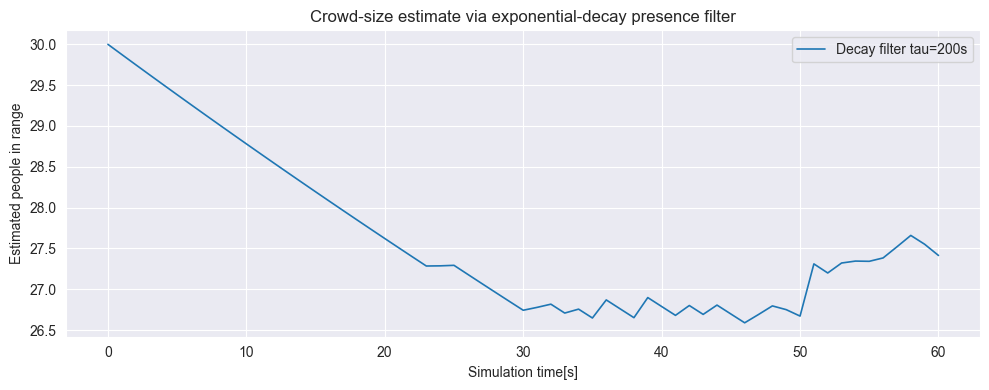

In [12]:
# build an index -> packets per STEP_SECONDS interval
t_min, t_max = 0, df["time"].max()
ts           = np.arange(t_min, t_max + STEP_SECONDS, STEP_SECONDS)
df["slot"]   = (df["time"] // STEP_SECONDS).astype(int)
pkts_by_slot = df.groupby("slot")["mac"].apply(list)    # list of MACs heard per slot

# presence filter loop

w        = defaultdict(float)      # current weight per MAC
decay    = math.exp(-STEP_SECONDS / TAU_SEC)
counts   = []

for slot in range(int(ts.size)):
    # 2a. decay all weights
    for mac in list(w):
        w[mac] *= decay
        if w[mac] < 1e-4:          # prune tiny weights
            w.pop(mac)

    # 2b. boost MACs heard in this slot
    if slot in pkts_by_slot.index:
        for mac in pkts_by_slot.loc[slot]:
            w[mac] = 1.0

    counts.append(sum(w.values()))

series = pd.Series(counts, index=ts, name="crowd_size_decay")

# simple evaluation
est_overall = int(round(series.median()))
error = est_overall - GROUND_TRUTH
print(f"Estimated crowd = {est_overall}  (tau = {TAU_SEC}s) " 
      f"-> error {error:+d} people")

# visualisation
plt.figure(figsize=(10,4))
plt.plot(series.index, series.values, lw=1.2, label=f"Decay filter tau={TAU_SEC}s")
plt.xlabel("Simulation time[s]")
plt.ylabel("Estimated people in range")
plt.title("Crowd-size estimate via exponential-decay presence filter")
plt.legend()
plt.tight_layout()
plt.show()


# ---------- Support-Vector Regression ------------------------------

SVR   MAE = 0.47  |  R² = 0.651
Estimated crowd = 27 (SVR) -> error +2 people


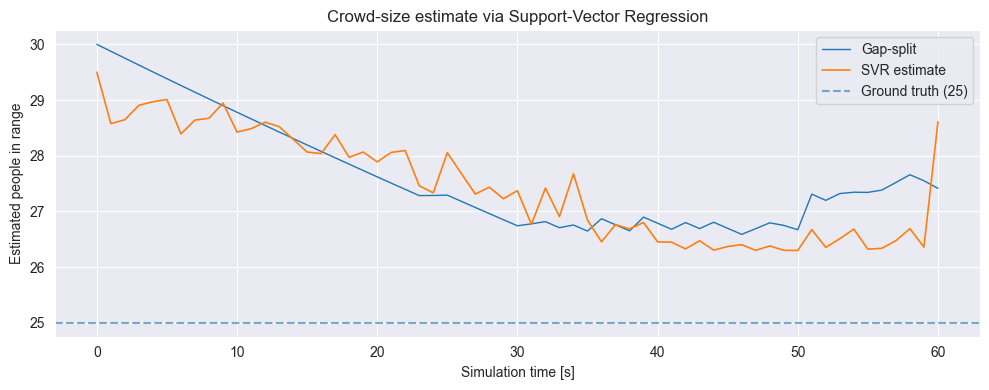

In [15]:
# build a feature matrix X[t] and silver-standard target y[t]
# features (computed once, reused later)
feat = defaultdict(list)          # will become a dict of lists indexed by slot
for slot in range(int(ts.size)):
    macs_this_slot = pkts_by_slot.get(slot, [])           # list, possibly empty
    feat["pkt_cnt"].append(len(macs_this_slot))
    feat["uniq_macs"].append(len(set(macs_this_slot)))

X = np.vstack([feat["pkt_cnt"], feat["uniq_macs"]]).T      # shape (T, 2)

# target : use the “gap-split” series you already calculated
y = series.values.astype(float)        # same length T as X, silver labels

# train / validate split  (80% / 20% chronological to avoid leakage)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# train the model
svr = make_pipeline(StandardScaler(),
                    SVR(kernel="rbf", C=10.0, epsilon=0.5, gamma="scale"))
svr.fit(X_train, y_train)

# evaluate and build the full-length series
y_pred = svr.predict(X)
mae   = mean_absolute_error(y, y_pred)
r2    = r2_score(y, y_pred)
print(f"SVR MAE = {mae:.2f}  |  R^2 = {r2:.3f}")

series_svr = pd.Series(y_pred, index=ts, name="crowd_size_svr")

# simple evaluation
est_overall = int(round(series_svr.median()))
error = est_overall - GROUND_TRUTH
print(f"Estimated crowd = {est_overall} (SVR) -> error {error:+d} people")

# visualization
plt.figure(figsize=(10,4))
plt.plot(series.index,         series.values,     lw=1.0, label="Gap-split")
plt.plot(series_svr.index,     series_svr.values, lw=1.2, label="SVR estimate")
plt.axhline(GROUND_TRUTH, ls="--", alpha=.6,      label=f"Ground truth ({GROUND_TRUTH})")
plt.xlabel("Simulation time [s]")
plt.ylabel("Estimated people in range")
plt.title("Crowd-size estimate via Support-Vector Regression")
plt.legend()
plt.tight_layout()
plt.show()


# ---------- PCA-assisted k-means clustering ------------------------------

Estimated crowd = 27 (k‑means) -> error +2 people
k‑means / gap‑split AdjustedRandIndex = 0.422


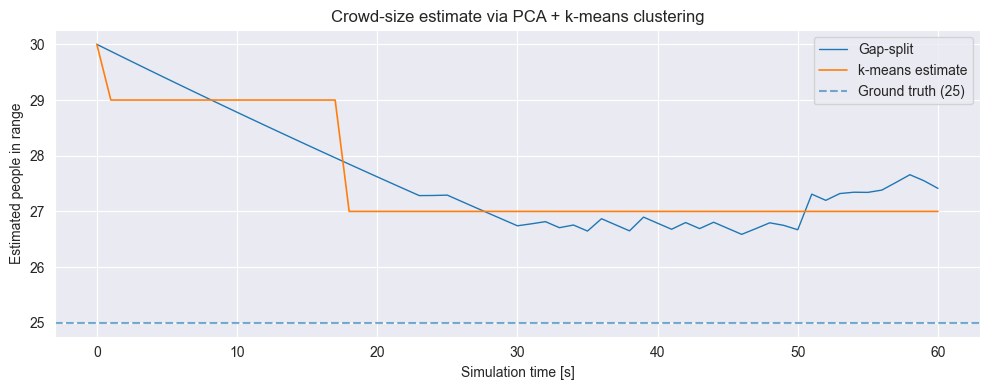

In [19]:
# feature matrix  (reuse what we built for SVR, but add more signal)
feat["sess_active"]   = []               # gap-split active sessions per slot

# pre-compute once to avoid loops inside the loop
gap_split_lookup = dict(zip(series.index.astype(int), series.values))

for slot in range(int(ts.size)):
    macs_this_slot = pkts_by_slot.get(slot, [])
    feat["pkt_cnt"][slot]        # already filled
    feat["uniq_macs"][slot]      # already filled

    # contextual feature: how many sessions are currently active?
    feat["sess_active"].append(gap_split_lookup.get(slot, 0))

# final feature matrix
X_full = np.vstack([feat["pkt_cnt"],
                    feat["uniq_macs"],
                    feat["sess_active"]]).T

# standardise
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

pca = PCA(n_components=0.95, svd_solver="full")
X_emb = pca.fit_transform(X_scaled)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters,
                n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_emb)

# map clusters
cluster2count = {}
for c in range(n_clusters):
    idx = (labels == c)
    cluster2count[c] = int(round(np.median(series[idx])))

# build the estimated crowd-size time series
kmeans_pred = np.vectorize(cluster2count.get)(labels)
series_km = pd.Series(kmeans_pred, index=ts, name="crowd_size_kmeans")

# simple evaluation
est_overall = int(round(series_km.median()))
error = est_overall - GROUND_TRUTH
print(f"Estimated crowd = {est_overall} (k-means) -> error {error:+d} people")

# optional sanity metric: how well do clusters align with silver labels?
ari = adjusted_rand_score(series.values.astype(int), labels)
print(f"k-means / gap-split AdjustedRandIndex = {ari:.3f}")

# visualization
plt.figure(figsize=(10,4))
plt.plot(series.index,         series.values,     lw=1.0, label="Gap-split")
plt.plot(series_km.index,      series_km.values,  lw=1.2, label="k-means estimate")
plt.axhline(GROUND_TRUTH, ls="--", alpha=.6,      label=f"Ground truth ({GROUND_TRUTH})")
plt.xlabel("Simulation time [s]")
plt.ylabel("Estimated people in range")
plt.title("Crowd-size estimate via PCA + k-means clustering")
plt.legend()
plt.tight_layout()
plt.show()
